## ML2 : FINAL PROJECT - Beat the Assessors
##### Author : Ran Huo
##### Date: 11/03/2023

# 1. Problem Statement

The final project for ML2 is selected to keep working on the CCAO's property dataset to build models that could better predict the property sale value in order to make more accurate property tax decisions annually. The sale price of the property is only available at the time when the property is sold. However, property owners are obligated by law to pay property tax annually. It is CCAO's responsibility to make sure each property is assessed appropriately in order to ensure a fair amount of tax. Overestimating the property sale value could result in over-taxing the property owner, whereas underestimation could lead to lowering the available funds for the government operation. As revealed previously, overestimation should be weighed more in terms of negative impact than underestimation. 

The objective of the project is to build a Machine Learning model that could beat the CCAO's current property sale value model's performance to better predict the property sale value before the sale happened based on the available features of the property. The problem would be a regression model since the target variable - sale price is numeric. A series of regressors would be fitted and tuned in order to achieve better model performance. 

In terms of evaluation metrics, besides the ones such as MAPE, and R-squared, according to the project instruction, "the assessors use a few metrics to judge the quality of assessment. The one we will focus on is the coefficient of dispersion (COD). This considers the ratio of what a property is valued at to how much it's actually worth. It compares on average the extent to which those ratios are different from the mean ratio--i.e., it measures the spread of ratios. A lower spread means that the assessment is more uniform across properties. A good COD is <15%. The goal is to achieve the best COD possible."

The project will go through the typical data science pipeline from EDA, data manipulation and preparation, to model fitting and evaluation. To compare apples to apples, the data manipulation will also be applied to the CCAO's assessment result in order to compare the CODs. After the model fitting and tuning, the highest COD that the model could achieve will be reported. 

# 2. Import Libraries

In [2]:
# Import the necessary mocules/libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew 
from scipy.stats import kurtosis
from scipy.stats import boxcox 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import geopandas as gpd
import descartes
from shapely.geometry import Point
d
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from yellowbrick.regressor import AlphaSelection, ManualAlphaSelection, ResidualsPlot
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbalancePipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score, accuracy_score,r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR

In [3]:
# Display plots
%matplotlib inline

In [91]:
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:.2f}'.format

# 3. CCAO's First Pass Model COD

In [5]:
#Read the sales dataset and the assessment dataset
sales_data = pd.read_csv("Cook_County_Assessor_s_Residential_Sales_Data.csv", low_memory = False)
assessments = pd.read_csv("Cook_County_Assessor_s_Residential_Assessments.csv", low_memory = False)

#Limit to single-family properties
classes = [202, 203, 204, 205, 206, 207, 208, 209, 210, 234, 278, 295]
sales_data = sales_data[sales_data["Property Class"].isin(classes)]

#Some properties were sold multiple times in 2019. Include only the final sale
sales_data = sales_data.set_index("PIN")[["Sale Price", "Sale Month of Year"]]
sales_data = sales_data.sort_values(by=["Sale Month of Year"], ascending=False)
sales_data = sales_data[~sales_data.index.duplicated(keep='first')]

#For the assessment data, only look at properties where modeling was performed
#assessments = assessments.set_index("PIN")["MODEL RESULT"].dropna()
assessments = assessments.set_index("PIN")["MODEL RESULT"].dropna()

#Join the sales dataset and the modeling dataset
df = sales_data.join(assessments)
df = df.dropna()

#For each property, calculate the ratio of estimated price to actual
df["Ratio"] = df["MODEL RESULT"]/df["Sale Price"]

#Filter out ratios that are very high
#This is one way to eliminate those properties that sold for a few bucks
df = df[df["Ratio"]<10]

#Calculate the COD across properties
abs_sum_ratios = np.sum(np.abs(np.median(df["Ratio"])-df["Ratio"]))
cod = (100*(abs_sum_ratios)/len(df))/df["Ratio"].median()
print("The COD is", cod)

The COD is 24.552404991373784


The objective for the final project is to beat the assessor's current model performance by evaluating the model's COD - coefficient of dispersion across all the properties. According to the project instructions, "This considers the ratio of what a property is valued at to how much it's actually worth. It compares on average the extent to which those ratios are different from the mean ratio--i.e., it measures the spread of ratios. A lower spread means that the assessment is more uniform across properties. A good COD is <15%."  

# 4. Import data

In [6]:
# Bring in the Sales df from CCAO and three external dfs 
df = pd.read_csv("Cook_County_Assessor_s_Residential_Sales_Data.csv", low_memory = False)
neighbor = pd.read_csv("Cook_County_Assessor_Neighborhood.csv", low_memory = False)
census = pd.read_csv("Cook_County_Assessor_Census.csv", low_memory = False)
model = pd.read_csv("Cook_County_Assessor_Model.csv", low_memory = False)

# Check the sizes
df.shape, neighbor.shape, census.shape, model.shape

((583370, 83), (846, 7), (1318, 78), (678656, 80))

# 5. Bring in the `township_name` and `triad_name` from neighbor df

In [7]:
# Select columns
neighbor = neighbor[['township_code','township_name', 'triad_name']]

# Drop duplicates 
neighbor = neighbor.drop_duplicates(['township_code','township_name'], keep = 'first')

# Merge to sale df
df = pd.merge(df,neighbor, left_on = ['Town Code'],right_on = ['township_code'],
              how = 'left', indicator = True)

# 6. Bring in the domographic features from census df

In [8]:
# Select columns 
census = census[['Census Tract Code','Total Population','Percent Population Hispanic', 
                 'Percent Population White', 'Percent Population Black', 'Percent Population Asian', 
                 'Percent Population Native American','Percent Population 2 or More Races', 
                 'Percent Population over age 25 - Education level less than High School',
                 'Percent Population over age 25 - High School or High School Equivalency',
                 'Percent Population over age 25 - with Bachelor Degree',
                 'Percent Population over age 25 - with Graduate Degree',
                 'Unemployment Rate','Average Household Income','Percent Population English Speaking Only',
                 'Percent Spanish Primary Language','Percent Korean Primary Language',
                 'Percent Chinese Primary Language','Percent Vietnamese Primary Language',
                 'Percent Arabic Primary Language','Percent Other Primary Language']]

# Check the overlap
df[df['Census Tract'].isin(census['Census Tract Code'])].shape[0]/df.shape[0]

# Merge to the sales df
df = pd.merge(df, census, left_on = 'Census Tract',right_on = 'Census Tract Code', how = 'left')

Around 99% of the Census Tract code in the main Sales df can be found in the census df. 

# 7. Bring in the useful features from the model df

In [9]:
# Select columns
model = model[['Property Index Number','Flood Risk Factor', 'Flood Risk Direction',
               'Road Proximity < 100 Feet', 'Road Proximity 101 - 300 Feet',
               'Tract Median Income']]

# Remove the dash
model['PIN'] = model['Property Index Number'].replace('-', '', regex=True).astype(int)

# Drop duplicates
model.drop_duplicates(['PIN'], keep = 'first', inplace=True)

# Bring in the features from the model df
df = pd.merge(df,model, on = 'PIN', how = 'left')

# 8. Process the dataframe

In [10]:
#Limit to single-family properties
classes = [202, 203, 204, 205, 206, 207, 208, 209, 210, 234, 278, 295]
df = df[df["Property Class"].isin(classes)]
#df['PIN'] = df['PIN'].astype('string')

#Some properties were sold multiple times in 2019. Include only the final sale
df = df.set_index("PIN")
df = df.sort_values(by=["Sale Month of Year"], ascending=False)
df = df[~df.index.duplicated(keep='first')]

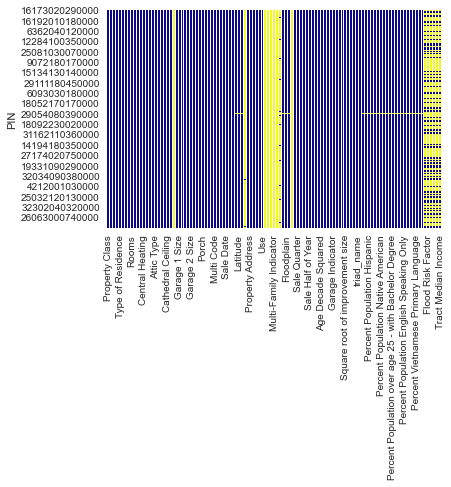

In [11]:
# Visualize the missing values
sns.heatmap(df.isnull(),cbar=False,cmap='plasma')
plt.show()

In [12]:
# Check the missing value percentage
miss = pd.DataFrame((df.isnull().sum()/(df.shape[0]))*100).reset_index()
miss.rename(columns = {"index":'column_name',
                       0:'% missing'}, inplace = True)
miss.sort_values(by = '% missing', ascending = False)

column_name  % missing
56                              Multi-Family Indicator        100
62                                        Condo Strata        100
57                                           Large Lot        100
55                                  Condo Class Factor        100
53                                     Number of Units        100
22                                          Renovation        100
54                                   Percent Ownership        100
46                          Total Building Square Feet         99
58                 Condition, Desirability and Utility         94
111                      Road Proximity 101 - 300 Feet         66
110                          Road Proximity < 100 Feet         66
109                               Flood Risk Direction         66
108                                  Flood Risk Factor         66
107                              Property Index Number         66
112                                Tract Median Income         66
87                                    Total Population          0
43                                           Longitude          0
44                                            Latitude          0
88                         Percent Population Hispanic          0
89                            Percent Population White          0
90                            Percent Population Black          0
91                            Percent Population Asian          0
92                  Percent Population Native American          0
93                  Percent Population 2 or More Races          0
94   Percent Population over age 25 - Education lev...          0
95   Percent Population over age 25 - High School o...          0
96   Percent Population over age 25 - with Bachelor...          0
97   Percent Population over age 25 - with Graduate...          0
98                                   Unemployment Rate          0
99                            Average Household Income          0
100           Percent Population English Speaking Only          0
101                   Percent Spanish Primary Language          0
102                    Percent Korean Primary Language          0
103                   Percent Chinese Primary Language          0
104                Percent Vietnamese Primary Language          0
105                    Percent Arabic Primary Language          0
106                     Percent Other Primary Language          0
45                                        Census Tract          0
59                                        O'Hare Noise          0
60                                          Floodplain          0
61                                      Road Proximity          0
86                                   Census Tract Code          0
48                                    Property Address          0
69                                    Most Recent Sale          0
68                                   Sale Half of Year          0
76                                    Garage Indicator          0
70                                         Age Squared          0
71                                          Age Decade          0
72                                  Age Decade Squared          0
73                                    Lot Size Squared          0
2                                     Land Square Feet          0
3                                            Town Code          0
4                                    Type of Residence          0
74                            Improvement Size Squared          0
75                                  Pure Market Filter          0
77                          Neigborhood Code (mapping)          0
6                                        Wall Material          0
78                             Square root of lot size          0
79                                  Square root of age          0
80                     Square root of improvement size          0
81               

In [13]:
# Use the average household income to approximate the median income to fill the missing values
# For the rest of the missing value, fillna using the median of the Tract Median Income
df.loc[df['Tract Median Income'].isnull(), 'Tract Median Income'] = df['Average Household Income']
df['Tract Median Income'] = df['Tract Median Income'].fillna(df['Tract Median Income'].median())

In [14]:
# Check the missing value percentage
miss = pd.DataFrame((df.isnull().sum()/(df.shape[0]))*100).reset_index()
miss.rename(columns = {"index":'column_name',
                       0:'% missing'}, inplace = True)
miss.sort_values(by = '% missing', ascending = False)

column_name  % missing
56                              Multi-Family Indicator        100
53                                     Number of Units        100
55                                  Condo Class Factor        100
57                                           Large Lot        100
62                                        Condo Strata        100
22                                          Renovation        100
54                                   Percent Ownership        100
46                          Total Building Square Feet         99
58                 Condition, Desirability and Utility         94
108                                  Flood Risk Factor         66
107                              Property Index Number         66
111                      Road Proximity 101 - 300 Feet         66
110                          Road Proximity < 100 Feet         66
109                               Flood Risk Direction         66
60                                          Floodplain          0
104                Percent Vietnamese Primary Language          0
86                                   Census Tract Code          0
61                                      Road Proximity          0
105                    Percent Arabic Primary Language          0
59                                        O'Hare Noise          0
89                            Percent Population White          0
43                                           Longitude          0
44                                            Latitude          0
45                                        Census Tract          0
88                         Percent Population Hispanic          0
87                                    Total Population          0
90                            Percent Population Black          0
97   Percent Population over age 25 - with Graduate...          0
103                   Percent Chinese Primary Language          0
102                    Percent Korean Primary Language          0
101                   Percent Spanish Primary Language          0
100           Percent Population English Speaking Only          0
99                            Average Household Income          0
98                                   Unemployment Rate          0
96   Percent Population over age 25 - with Bachelor...          0
95   Percent Population over age 25 - High School o...          0
94   Percent Population over age 25 - Education lev...          0
93                  Percent Population 2 or More Races          0
92                  Percent Population Native American          0
106                     Percent Other Primary Language          0
91                            Percent Population Asian          0
48                                    Property Address          0
69                                    Most Recent Sale          0
66                                Sale Quarter of Year          0
67                                  Sale Month of Year          0
68                                   Sale Half of Year          0
70                                         Age Squared          0
82                                       township_code          0
71                                          Age Decade          0
72                                  Age Decade Squared          0
73                                    Lot Size Squared          0
74                            Improvement Size Squared          0
75                                  Pure Market Filter          0
76                                    Garage Indicator          0
77                          Neigborhood Code (mapping)          0
78                             Square root of lot size          0
79                                  Square root of age          0
80                     Square root of improvement size          0
81                               Town and Neighborhood          0
64                                        Sale Quarter          0
83               

In [15]:
# Remove the columns with over 60% of the missing values
keep = miss[miss['% missing'] < 60]['column_name'].to_list()
df = df[keep]
df.shape

(259531, 99)

# 9. Align data type

In [16]:
#****** Type of Residence ******
TOR_map = {1:'one story',2:'two-story',3:'three-story or higher',
           4:'split level',5:'1.5 story',6:'other',
           7:'other',8:'other',9:'other'
          }

df['Type of Residence'] = df['Type of Residence'].map(TOR_map)

#****** Wall Material ******
Wall_map = {1:'Wood',2:'Masonry',
            3:'Wood&Masonry',4:'Stucco'}

df['Wall Material'] = df['Wall Material'].map(Wall_map)

#****** Roof Material ******
Roof_map = {1:'Shingle/Asphalt',2:'Tar&Gravel',3:'Slate',
            4:'Shake',5:'Tile',6:'Other'}

df['Roof Material'] = df['Roof Material'].map(Roof_map)

#****** Basement ******
Base_map = {1:'Full',2:'Slab',
            3:'Partial',4:'Crawl'}

df['Basement'] = df['Basement'].map(Base_map)

#****** Basement Finish ******
BaseFinsh_map = {1:'Formal rec room',2:'Apartment',3:'Unfinished'}

df['Basement Finish'] = df['Basement Finish'].map(BaseFinsh_map)

#****** Central Heating ******
heat_map = {1:'Warm air',2:'Hot water steam',
            3:'Electric',4:'Other'}

df['Central Heating'] = df['Central Heating'].map(heat_map)

#****** Other Heating - majority is none Use it to fill the null in Central Heating ******
df.loc[df['Central Heating'].isnull(), 'Central Heating'] = df['Other Heating']
df.loc[df['Central Heating'] == 2.0, 'Central Heating'] = 'Unit heater'
df.loc[df['Central Heating'] == 5.0, 'Central Heating'] = 'None'

#****** Attic Type ******
att_map = {1:'Full',2:'Partial',3: 'None'}

df['Attic Type'] = df['Attic Type'].map(att_map)

#****** Attic Finish ******
att_finish_map = {1:'Living Area',2:'Apartment', 
                  3:'Unfinished',4:'None'}

df['Attic Finish'] = df['Attic Finish'].map(att_finish_map)

#****** Combine Attic Finish and Type ****** 
df['Attic'] = df['Attic Type'] + '-' + df['Attic Finish']

#****** Manipulate on Attic ****** 
df['Attic'] = df['Attic'].fillna('None')
df.loc[df['Attic'] == 'None-Unfinished', 'Attic'] = 'None'
df.loc[df['Attic'] == 'Full-Apartment', 'Attic'] = 'Full-Living Area'
df.loc[df['Attic'] == 'Partial-Apartment', 'Attic'] = 'Partial-Living Area'

In [17]:
#****** Design Plan ****** 
design_map = {0:'None',1:'Architect',2:'Stock Plan'}
df['Design Plan'] = df['Design Plan'].map(design_map)

#****** Construction Quality ****** 
cons_map = {1:'Deluxe',2:'Average',3:'Poor'}
df['Construction Quality'] = df['Construction Quality'].map(cons_map)

#****** Garage size ******
g_size_map = {1: '1 car',2: '1.5 car',3: '2 cars',
              4: '2.5 cars',5: '3 cars',6: '3.5 cars',
              7: 'None',8: '4 cars'}

df['Garage 1 Size'] = df['Garage 1 Size'].map(g_size_map)
df['Garage 2 Size'] = df['Garage 2 Size'].map(g_size_map)

#****** Manipulate and combine Garage 1 and 2 ******
df.loc[(df['Garage 1 Size'].isin(['1 car','1.5 car'])), 'Garage 1 Size'] = '1-1.5 car'
df.loc[(df['Garage 1 Size'].isin(['2 cars','2.5 cars'])), 'Garage 1 Size'] = '2-2.5 cars'
df.loc[(df['Garage 1 Size'].isin(['3 cars','3.5 cars'])), 'Garage 1 Size'] = '3-3.5 cars'
df.loc[(df['Garage 1 Size'].isin(['4 cars'])), 'Garage 1 Size'] = '4 cars'
df['Garage 1 Size'] = df['Garage 1 Size'].fillna('None')
df['Garage Size'] = df['Garage 1 Size']

#****** Garage 1 Material ******
gm_map = {0:'None',1:'Frame',2:'Masonry',
          3:'Frame/Masonry',4: 'Stucco'}

df['Garage Material'] = df['Garage 1 Material'].map(gm_map)

#****** Garage features ******
df['Garage Attachement'] = df['Garage 1 Attachment']
df['Garage Area'] = df['Garage 1 Area']

#****** Porch ****** 
porch_map = {1:'Frame',2:'Masonry',3:'None'}
df['Porch'] = df['Porch'].map(porch_map)

#****** Repair Condition ****** 
repair_map = {1:'Above Average',2:'Average',3:'Below Average'}
df['Repair Condition'] = df['Repair Condition'].map(repair_map)

Only 149 properties have second garage, will only use Garage 1 information. 

In [18]:
#****** Combine Estimate(Land) and Estimate(Building) ******  
df['Estimate_Market_Value'] = df['Estimate (Land)'] + df['Estimate (Building)']

#****** Combine Bathroom ******  
df['Bathroom'] = df['Full Baths'] + 0.5 * df['Half Baths']

#****** Convert Multi Code into Binary ******  
df['Multi Code'] = df['Multi Code'].apply(lambda x: 1 if x == 2 else 0)

#****** Convert Number of Commercial Units into Binary ******  
df['Commercial Units'] = df['Number of Commercial Units'].apply(lambda x: 1 if x>0 else 0)

#****** Convert use to single family or not binary ******  
df['Single Family Use'] = df['Use'].apply(lambda x: 1 if x == 1 else 0)

#****** Fill nas ******  
df['O\'Hare Noise'] = df['O\'Hare Noise'].fillna(0)
df['Floodplain'] = df['Floodplain'].fillna(0)
df['Road Proximity'] = df['Road Proximity'].fillna(0)
df['Most Recent Sale'] = df['Most Recent Sale'].fillna(0)

#****** Garage Attachment ******  
df['Garage Attachement'] = df['Garage Attachement'].apply(lambda x: 1 if x == 1 else 0)

#****** Garage Area ******  
df['Garage Area'] = df['Garage Area'].apply(lambda x: 1 if x == 1 else 0)

In [19]:
#****** Select columns ****** 
df = df[['Land Square Feet','Type of Residence', 'Wall Material','Roof Material', 
         'Rooms', 'Basement','Basement Finish', 'Central Heating',
         'Central Air', 'Fireplaces', 'Attic','Design Plan', 'Construction Quality', 
         'Porch', 'Building Square Feet', 'Repair Condition', 'Multi Code','Estimate_Market_Value',
         'Sale Price','Longitude', 'Latitude','Multi Property Indicator',
         'Age', "O'Hare Noise", 'Floodplain','Road Proximity', 'Sale Year',
         'Most Recent Sale', 'Pure Market Filter','Garage Indicator','township_name', 'triad_name', 
         'Total Population', 'Percent Population Hispanic', 'Percent Population White','Percent Population Black', 
         'Percent Population Asian','Percent Population Native American','Percent Population 2 or More Races',
         'Percent Population over age 25 - Education level less than High School',
         'Percent Population over age 25 - High School or High School Equivalency',
         'Percent Population over age 25 - with Bachelor Degree',
         'Percent Population over age 25 - with Graduate Degree',
         'Unemployment Rate', 'Percent Population English Speaking Only','Percent Spanish Primary Language',
         'Percent Chinese Primary Language','Percent Arabic Primary Language','Tract Median Income',
         'Garage Size', 'Garage Material', 'Bathroom', 'Garage Attachement', 'Garage Area']]

df.shape

# fillna with Median
df = df.fillna(df.median())

In [20]:
#****** Convert to Categorical ******
to_categorical = {'Type of Residence':'category',
                  'Wall Material':'category',
                  'Roof Material':'category',
                  'Basement':'category',
                  'Basement Finish':'category',
                  'Central Heating':'category',
                  'Attic':'category',
                  'Design Plan':'category',
                  'Construction Quality':'category',
                  'Repair Condition':'category',
                  'Sale Year':'category',
                  'township_name':'category',
                  'triad_name':'category',
                  'Garage Size':'category',
                  'Garage Material':'category',
                  'Porch':'category'}

# Convert data type
df = df.astype(to_categorical)

In [21]:
num = df.select_dtypes(include = 'number')
cat = df.select_dtypes(include = 'category')

# 10. Data Exploration - Numeric

In [22]:
num_cols = num.columns.to_list()

## 10.1 Numeric Features Distribution & Skewness

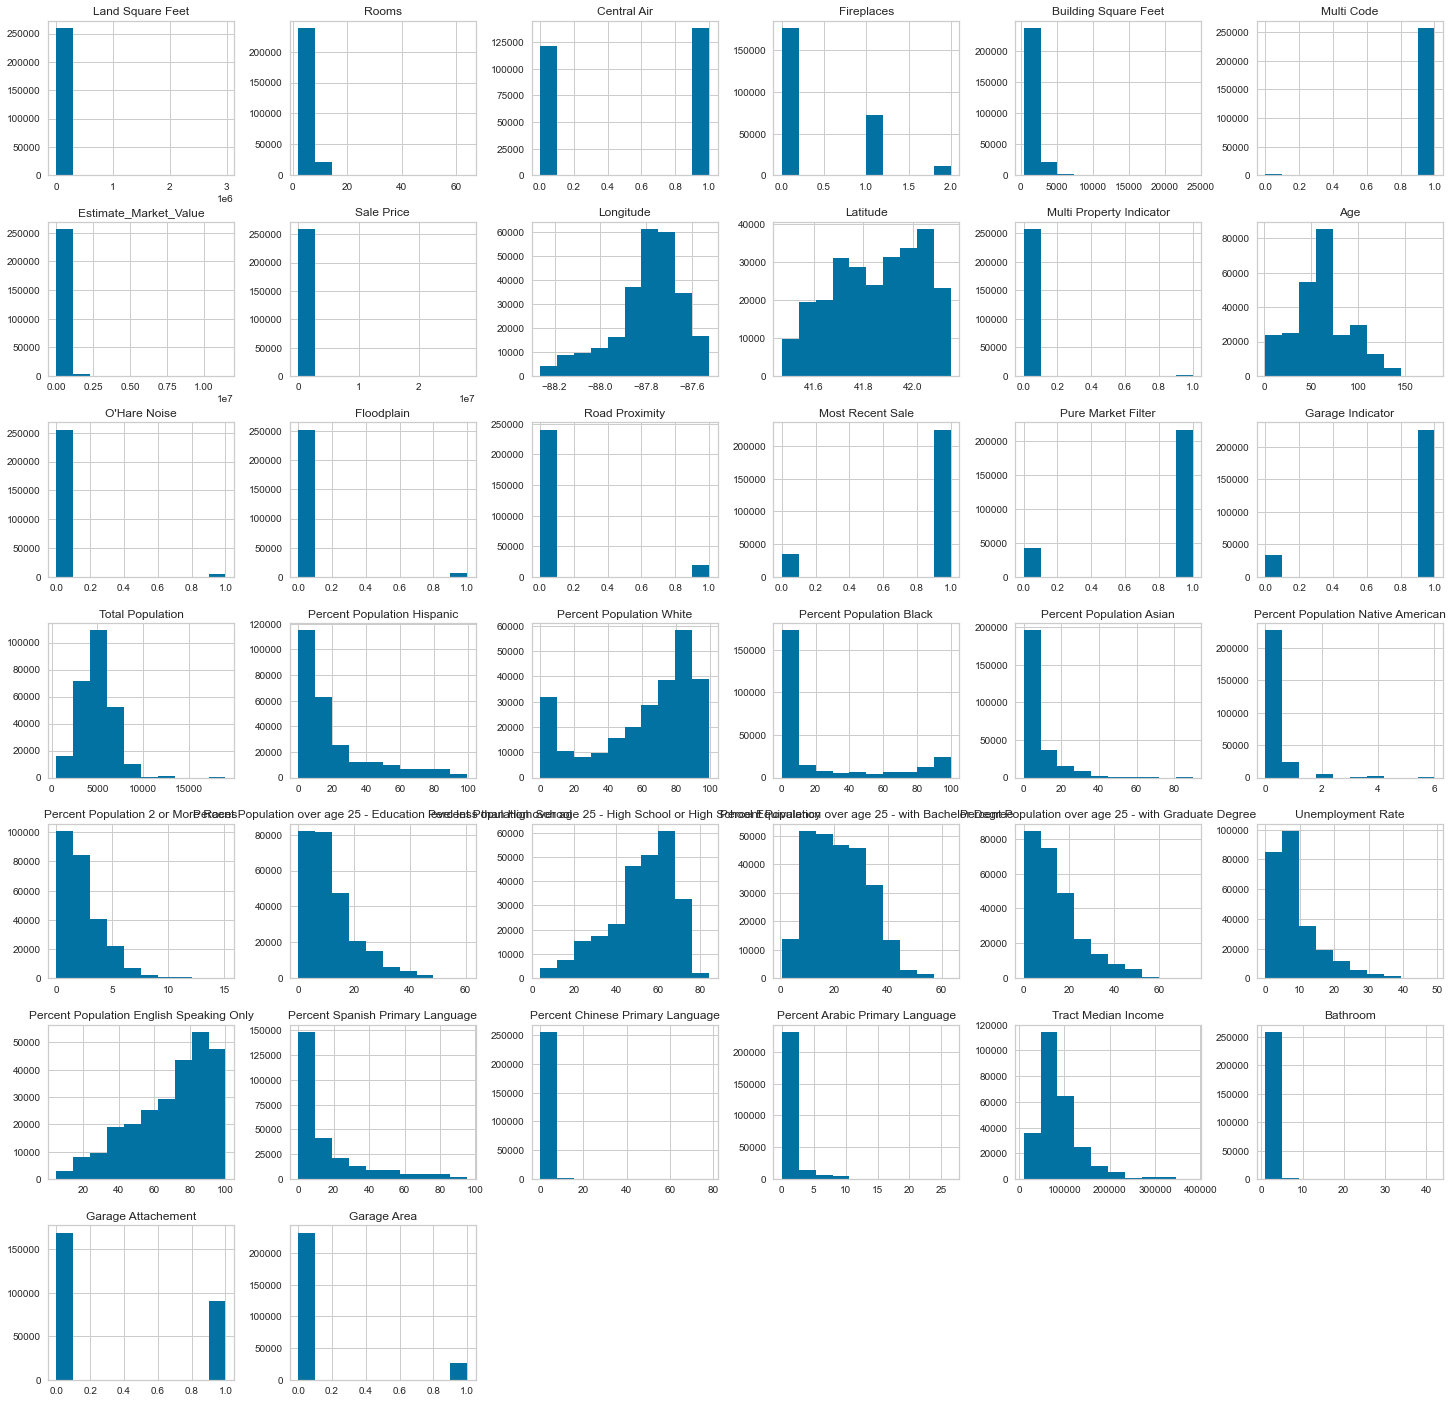

In [23]:
df.hist(column = num_cols, figsize = (25,25))
plt.show()

In [24]:
# Check for skewness and kurtosis
s = []
k = []

for i in num_cols:
        
    # Measure skew, correcting for bias
    sk = skew(num[i], bias = False)
    s.append(sk)
    
    # Measure kurtosis, correcting for bias (and no excess kurtosis)
    ku = kurtosis(num[i], bias = False, fisher = False)
    k.append(ku)
    
# put the result into a dataframe to display    
stat = pd.DataFrame(
                   {'Features': num_cols,
                    'Skewness': s,
                    'Kurtosis': k})

stat.sort_values('Skewness', ascending = False)

Features  Skewness  Kurtosis
0                                    Land Square Feet        75     12063
32                   Percent Chinese Primary Language        13       227
10                           Multi Property Indicator        12       147
12                                       O'Hare Noise         8        58
7                                          Sale Price         8       311
6                               Estimate_Market_Value         7       130
13                                         Floodplain         6        35
33                    Percent Arabic Primary Language         5        33
23                 Percent Population Native American         4        29
14                                     Road Proximity         3        12
4                                Building Square Feet         3        18
37                                        Garage Area         3         8
22                           Percent Population Asian         2        12
34                                Tract Median Income         2        10
35                                           Bathroom         2        30
31                   Percent Spanish Primary Language         2         6
29                                  Unemployment Rate         2         7
19                        Percent Population Hispanic         2         5
24                 Percent Population 2 or More Races         1         6
25  Percent Population over age 25 - Education lev...         1         5
21                           Percent Population Black         1         3
1                                               Rooms         1        13
28  Percent Population over age 25 - with Graduate...         1         5
3                                          Fireplaces         1         4
18                                   Total Population         1         7
36                                 Garage Attachement         1         1
27  Percent Population over age 25 - with Bachelor...         0         3
11                                                Age         0         3
2                                         Central Air        -0         1
9                                            Latitude        -0         2
30           Percent Population English Speaking Only        -1         3
26  Percent Population over age 25 - High School o...        -1         3
20                           Percent Population White        -1         2
8                                           Longitude        -1         4
16                                 Pure Market Filter        -2         4
15                                   Most Recent Sale        -2         6
17                                   Garage Indicator        -2         6
5                                          Multi Code       -10        95

In [25]:
# Check the descritpive statistics 
des = []

for i in num_cols:
    
    des.append(np.array(num[i].describe()))

a = pd.DataFrame(des, columns = ['count',
                                 'mean',
                                 'std',
                                 'min',
                                 '25%',
                                 '50%',
                                 '75%',
                                 'max'])
a['col'] = num.columns
a.set_index('col')

count   mean    std  min  \
col                                                                            
Land Square Feet                                   259531   7639  14544  170   
Rooms                                              259531      6      2    2   
Central Air                                        259531      1      0    0   
Fireplaces                                         259531      0      1    0   
Building Square Feet                               259531   1618    814  392   
Multi Code                                         259531      1      0    0   
Estimate_Market_Value                              259531 267829 247857    0   
Sale Price                                         259531 249019 310025    0   
Longitude                                          259531    -88      0  -88   
Latitude                                           259531     42      0   41   
Multi Property Indicator                           259531      0      0    0   
Age                                                259531     61     29    1   
O'Hare Noise                                       259531      0      0    0   
Floodplain                                         259531      0      0    0   
Road Proximity                                     259531      0      0    0   
Most Recent Sale                                   259531      1      0    0   
Pure Market Filter                                 259531      1      0    0   
Garage Indicator                                   259531      1      0    0   
Total Population                                   259531   4950   1757  507   
Percent Population Hispanic                        259531     20     22    0   
Percent Population White                           259531     61     30    0   
Percent Population Black                           259531     22     33    0   
Percent Population Asian                           259531      6      9    0   
Percent Population Native American                 259531      0      1    0   
Percent Population 2 or More Races                 259531      2      2    0   
Percent Population over age 25 - Education leve... 259531     12      9    0   
Percent Population over age 25 - High School or... 259531     52     16    4   
Percent Population over age 25 - with Bachelor ... 259531     22     11    0   
Percent Population over age 25 - with Graduate ... 259531     15     11    0   
Unemployment Rate                                  259531      9      7    0   
Percent Population English Speaking Only           259531     69     22    5   
Percent Spanish Primary Language                   259531     16     20    0   
Percent Chinese Primary Language                   259531      1      3    0   
Percent Arabic Primary Language                    259531      1      2    0   
Tract Median Income                                259531  89363  48835 9787   
Bathroom                                           259531      2      1    1   
Garage Attachement                                 259531      0      0    0   
Garage Area                                        259531      0      0    0   

                                                      25%    50%    75%  \
col                                                                       
Land Square Feet                                     3780   5969   8580   
Rooms                                                   5      6      7   
Central Air                                             0      1      1   
Fireplaces                                              0      0      1   
Building Square Feet                                 1092   1356   1894   
Multi Code                                              1      1      1   
Estimate_Market_Value                              136310 207920 307260   
Sale Price                                          62538 187000 317500   
Longitude                                             -88    -88    -88   
Latitude                  

By checking the distribution, statistics, skewness, and kurtosis, variables such as `Land Square Feet`, and `Percent Chinese Primary Language` are highly skewed and have high Kurtosis. Also, when we look at the scales of the features, there're features such as `Land Square Feet`,` Building Square Feet`, `Estimate_Market_Value`, `Total Population`, and `Tract Median Income`, which are on a significantly larger scale. Before we put the features into modeling, these features will need to be scaled.

## 10.2 Numeric Features - Correlation Matrix

In [26]:
# Create correlation matrix for the regression model. 
corrMatrix = num.corr(method = 'pearson')

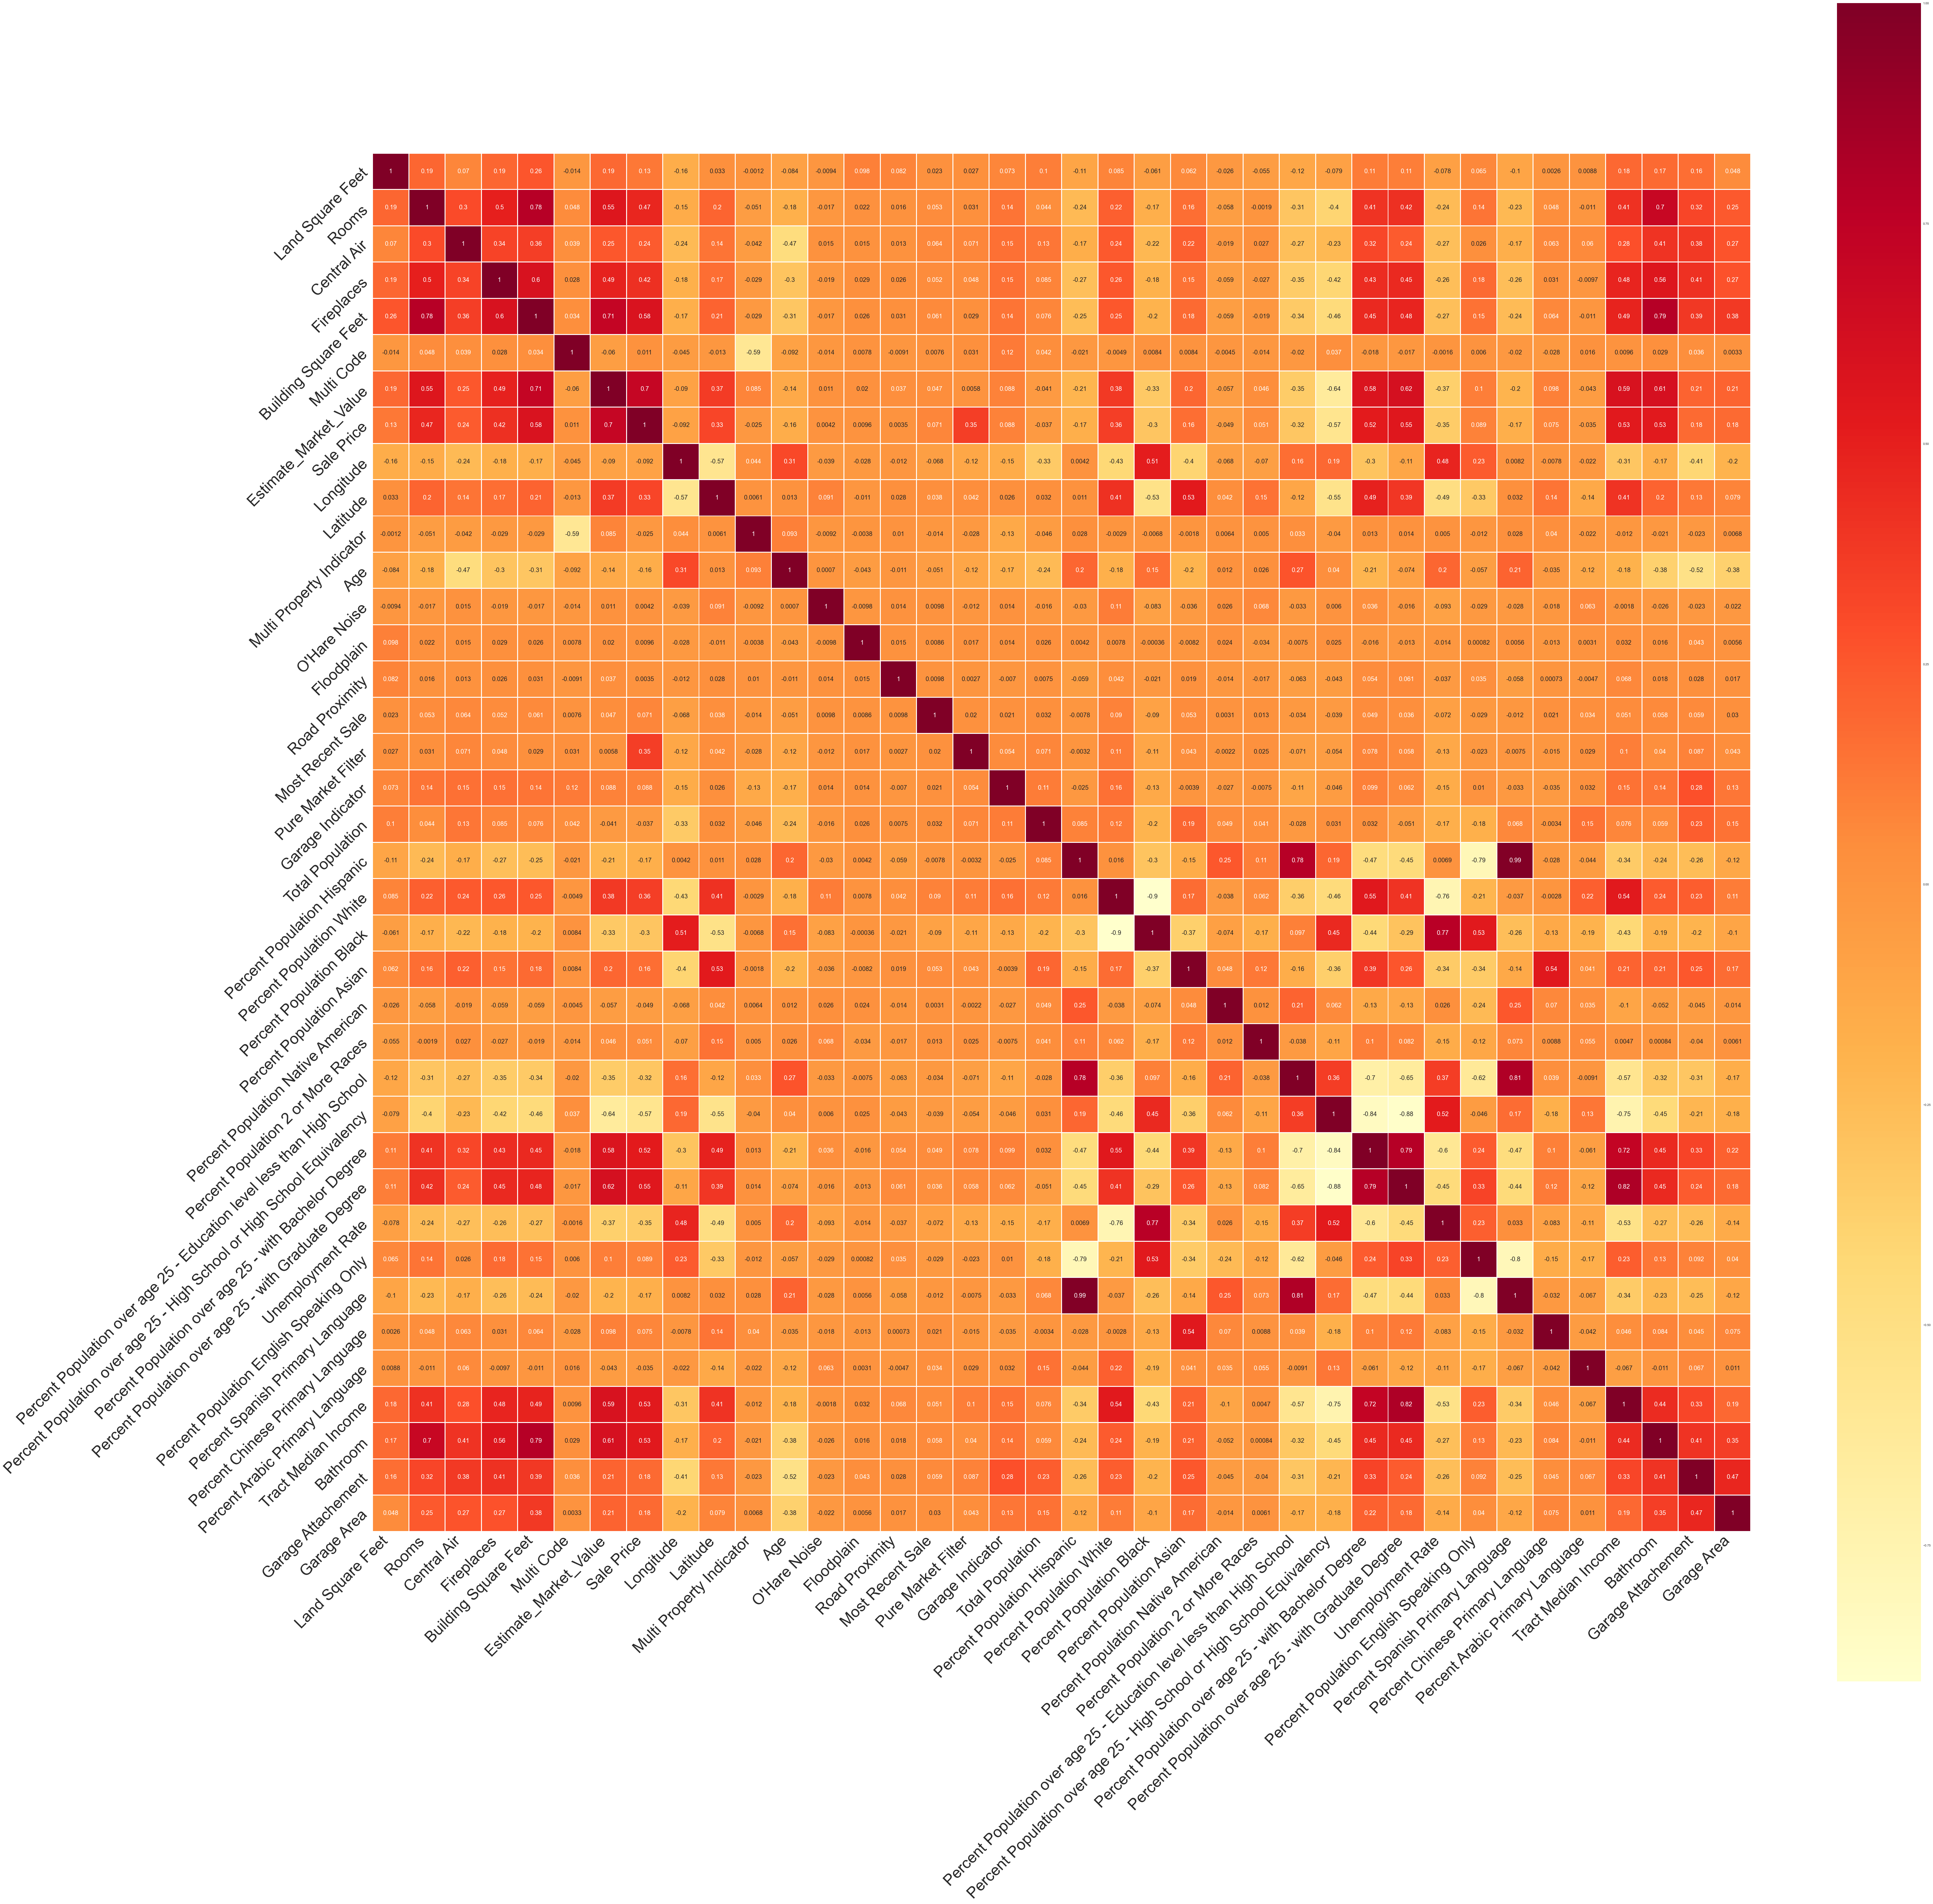

In [27]:
# Set the plot size
f, ax = plt.subplots(figsize=(100,100)) 

# Create seaborn objective, with annotation being true, square being ture, color = cmap, distance between cells = linewidth
# annotation size = annot_kws
ax = sns.heatmap(corrMatrix,annot = True, square = True, cmap = "YlOrRd",linewidth=2, annot_kws={"size": 20} )

# Set the bottom and top length to avoid cutoff 
bottom, top = ax.set_ylim()
ax.set_ylim(bottom, top)

# Rotate the tick marks and make the tickmark label font size bigger
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=50)

From the above correlation matrix heatmap, we could see there are medium to strong correlations between the independent variables and the dependent variable `Sale Price`, which is a good sign for modeling. We also see some of the predictors have a strong correlation among themselves. The strong correlation among predictors could potentially lead to the multicollinearity issue, where predictors explain each other instead of explaining the dependent variable. To understand the severity of multicollinearity, we could refer to the VIF values for each numeric feature. 

## 10.3 Categorical Variables - Interaction between IVs and DV

In [28]:
cat_cols = cat.columns.to_list()

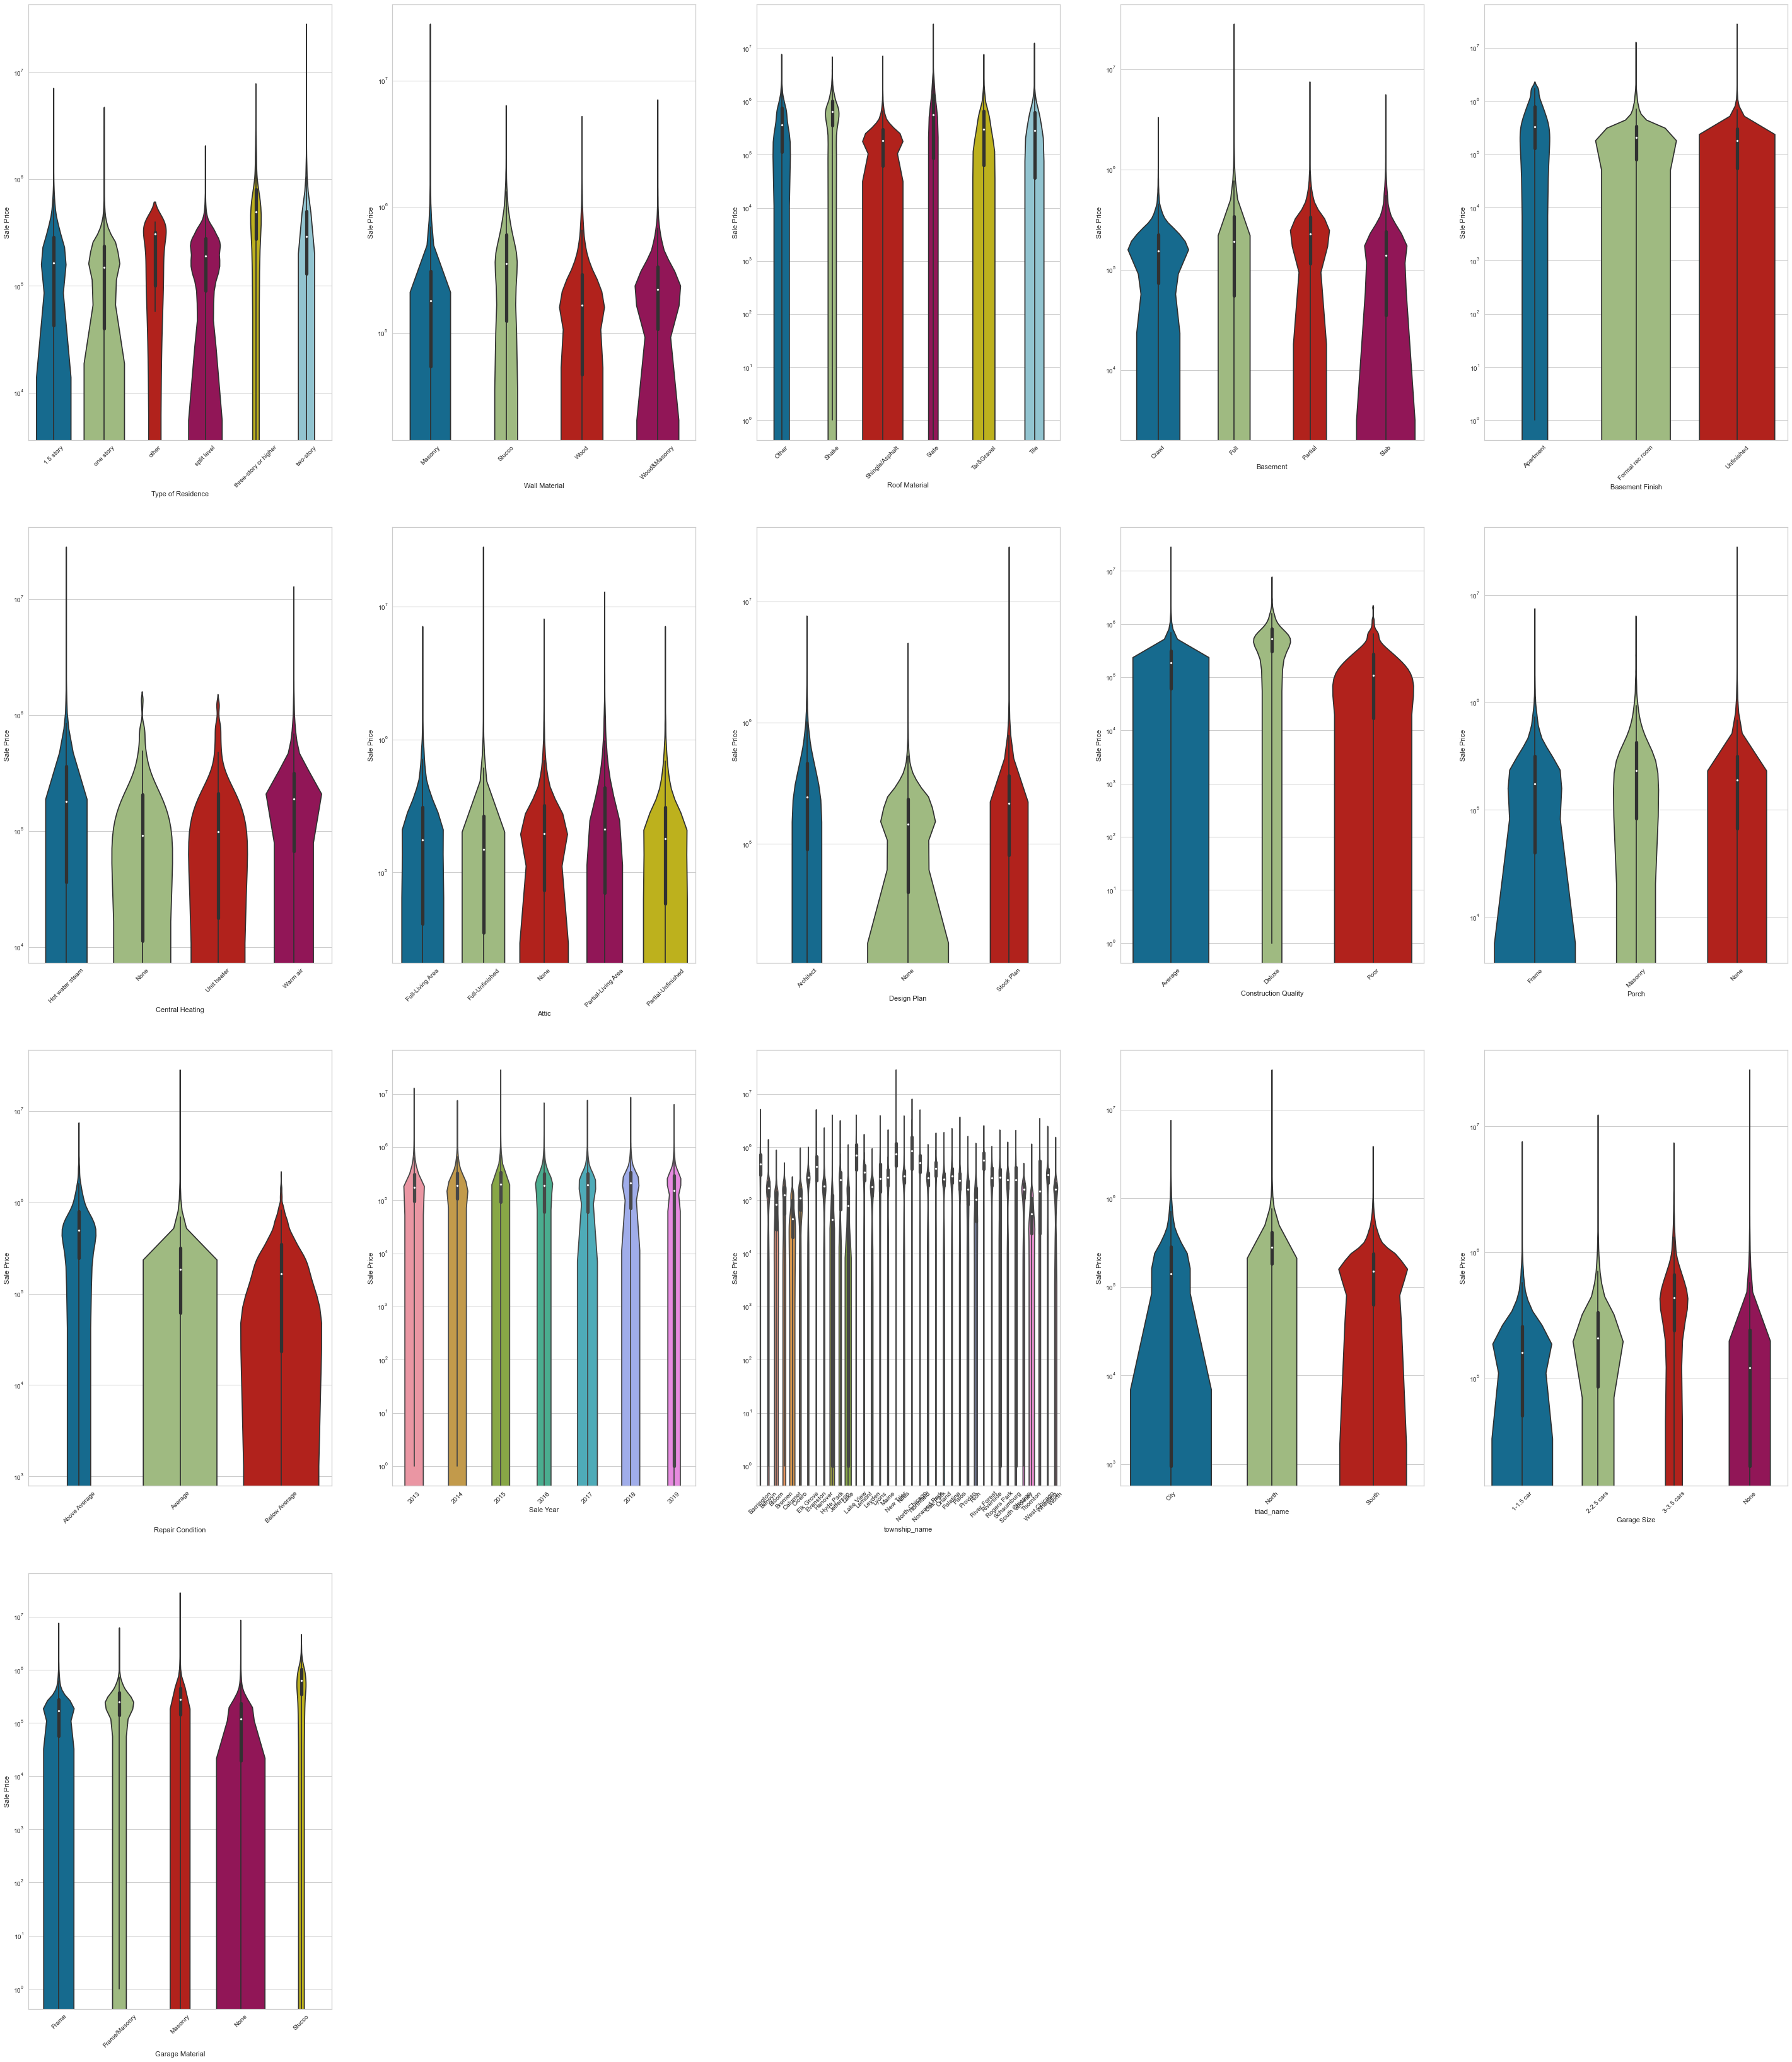

In [29]:
# Loop through each categorical variable and create violin plot between each categorical 
# variable and the dependent variable value.  
plt.figure(figsize=(50, 150))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(10, 5, i) 
    ax = sns.violinplot(x=cat[col], y=df['Sale Price'])
    ax.set(yscale = 'log')
    ax = ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

Due to the extreme outliers and skewness, to see the distribution of Sales Price in the lower spectrum, it is decided to use the log scale of the Sale Price. 

As the violin plot shows both the dispersion and the distribution of Sale Price against each individual categorical variable, we will see if the median and the box have a large overlap (insignificant difference of Sale Price among different categories) or a small overlap (significant difference of Sale Price among different categories). 

We can spot the small overlaps among the boxplots for some of the categorical variables, which indicates significance in predicting the Sale Prices of the properties. 

## 10.4 Target Variable - Sales Price

### 10.4.1 Check Distribution

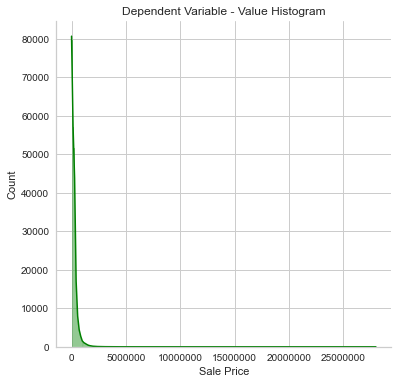

In [30]:
# Create a histogram
fig, ax = plt.subplots(figsize=(6, 6))
sns.set_theme(style="white", palette=None)
ax = sns.histplot(data=df, x="Sale Price", kde=True, bins = 20, color = 'green', binwidth = 100000)
sns.despine()
ax.set_title('Dependent Variable - Value Histogram')
# Remove the Scientific Notation
ax.ticklabel_format(style = 'plain', axis='x')

In [31]:
# Measure skew, correcting for bias
SP_skew = skew(df['Sale Price'], bias = False)
    
# Measure kurtosis, correcting for bias (and no excess kurtosis)
SP_kurt = kurtosis(df['Sale Price'], bias = False, fisher = False)
    
print("The skewness is %f" %(SP_skew))
print("The kurtosis is %f" %(SP_kurt))

The skewness is 7.536871
The kurtosis is 311.023039


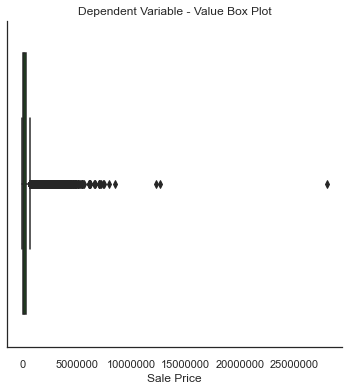

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.boxplot(x=df['Sale Price'], color = 'green')
sns.despine()
ax.set_title('Dependent Variable - Value Box Plot')
# Remove the Scientific Notation
ax = ax.ticklabel_format(style = 'plain', axis='x')

We can see the target variable is positively skewed to the right and has a very high kurtosis indicating a large amount of Sale Price gathered around the center of the distribution. From the boxplot, we can see a number of high-value outliers. It is decided to normalize it by taking a log transformation.

By checking the Sale Price on the lower end, for Cook County property, it is unrealistic to see properties that sold for less than 50K even for the properties that are located on the South Side of Chicago with a high crime rate and poverty rate. For those properties that had lower than 50K sale price, it could be due to the data collection error. To find a balance between maintaining the quality of the data but also not trimming down too much data, it is decided to set the threshold to 5000 dollars. If the property is sold for less than 5000 dollars, it will be removed from the analysis. As checked, we will remove 40K data, which is 15% of the entire dataset. 

### 10.4.2 Outlier and Inconsistency Sale Price

In [33]:
df['Sale Price'].describe()

count     259531
mean      249019
std       310025
min            0
25%        62538
50%       187000
75%       317500
max     28000000
Name: Sale Price, dtype: float64

From the exploratory analysis above, we can see property sale prices ranging from 0 to 28 million. Outliers had been detected on both the high end and low end of the sale prices. 

According to RocketHome Morgage company's website, - https://www.rockethomes.com/real-estate-trends/il/cook-county#:~:text=Summary%3A%20The%20median%20home%20sold,per%20square%20foot%20was%20%24203. Cook County property median sale price is around 300k. By checking the properties that sold less than 50k on the real estate website - Redfin, based on the sale history, most of the properties with less than 10k sale price had inconsistent data issues. 

For example, for the property with PIN: 13192030230000, in the Cook County Sale dataset, the Sale price is only 1 dollar and the estimated market value is 290K and it was sold in 2019. Based on Redfin data - https://www.redfin.com/IL/Chicago/6428-W-Dakin-St-60634/home/13469670, the property was sold on 10/21/2021 with the sale price of 270K. According to the sale history, the lowest amount of the sale price was 80K back in 1983. 1 dollar of the sale price is apparently a data entry error. 

After randomly reviewing 10 properties that had a sale price of less than 50K, all 10 properties had the same inconsistency issue. It was decided to remove those properties that had a sale price of less than 50K. For the properties that had estimated market value - estimate land plus estimate building value, it is decided to do the same manipulation by removing those properties with less than 50k estimated market value. 

In [34]:
# Remove sale price less than 50K
df = df[df['Sale Price'] > 50000]
df = df[df['Estimate_Market_Value'] > 50000]

In [35]:
df.shape

(198065, 54)

In [36]:
df['Sale Price'].describe()

count     198065
mean      320928
std       320672
min        50001
25%       155500
50%       239000
75%       367500
max     28000000
Name: Sale Price, dtype: float64

After the removal of inconsistent data in the lower end, there are properties that in both the high and low end of the sale prices that have a huge gap between the estimated market value and the sale value. Per CCAO, the estimated market value - estimate land plus estimate building is the 'Board of Review final estimated market value of land from the prior tax year'. The huge gap between the estimated market value and the sale price raises a red flag for the properties.  

To systematically solve those inconsistent data points, it is decided to calculate a ratio between the absolute value of the delta of estimated market value and sale price and either the sale price or estimated market value, whichever is smaller. The idea behind this is that the delta of the two values should not be greater than two times the sale price or estimated market value. 

The threshold of 2 is decided based on the understanding of the Cook County property sale price. Basically, for those properties where the absolute value of the delta between estimated market value and sale price exceeds 2, there's a high chance it is caused by the data inconsistency issue either due to the data entry or outdated data. 

For example, a property is estimated to be 100k but the sale price is 400k. The ratio is calculated as 3. It could be due to the fact that the property had been remodeled by adding a second floor and increased the home sale value drastically. However, since any large-scale remodeling or flip project needs city or county permits and there are inspectors check the quality of the projects, it is assumed that the CCAO property data should be updated accordingly. If this is not the case, it is highly recommended for CCAO to update the property data to reflect the most updated characteristics of the property. 

For this project, to solve those inconsistent data, it is decided to remove those properties that have the above-described ratio over 2 - equal either the estimated market value is 3 times of sale price or vas versa. 

After the removal, by randomly checking both extremely high and extremely low sale price properties on Redfin, the inconsistency issue in sale price was not spotted anymore. 

As checked, it will only remove less than 5% of the data. 

In [37]:
# Calculate the delta_ratio
df.loc[df['Estimate_Market_Value'] >= df['Sale Price'], 'delta_ratio'] = \
    (np.abs(df['Estimate_Market_Value'] - df['Sale Price']))/df['Sale Price']
df.loc[df['Estimate_Market_Value'] < df['Sale Price'], 'delta_ratio'] = \
    (np.abs(df['Estimate_Market_Value'] - df['Sale Price']))/df['Estimate_Market_Value']

# Remove the ratio over 2 properties
df = df[df['delta_ratio'] <= 2]

In [38]:
df.shape

(195247, 55)

In [39]:
# Log Transform the Dependent variable value
df['ln_sale'] = np.log(df["Sale Price"])

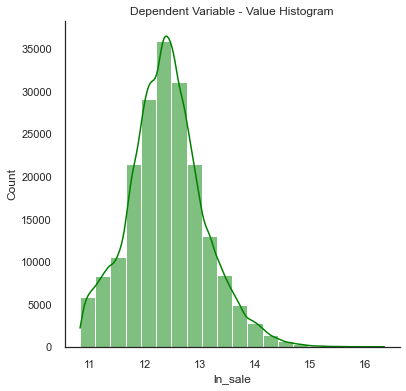

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.set_theme(style="white", palette=None)
ax = sns.histplot(data=df, x="ln_sale", kde=True, bins = 20, color = 'green')
sns.despine()
ax.set_title('Dependent Variable - Value Histogram')
# Remove the Scientific Notation
ax.ticklabel_format(style = 'plain', axis='x')

In [41]:
# Create a copy of the prepared df
df_prepared = df.copy()

As we can see, by removing the suspeciously low sale tags and taking the log transformation, the histogram of ln_sale looks normal now. 

### 10.4.3 Check CCAO Model COD on Manipulated Data

Again, to compare apple to apple, we should examine the COD on the updated dataframe. 

In [42]:
# Bring in assessments
assessments = pd.read_csv("Cook_County_Assessor_s_Residential_Assessments.csv", low_memory = False)

# Create a copy of sale data df
df1 = df.copy()

#For the assessment data, only look at properties where modeling was performed
assessments = assessments.set_index("PIN")["MODEL RESULT"].dropna()

#Join the sales dataset and the modeling dataset
df1 = df1.join(assessments)
df1 = df1.dropna()

#For each property, calculate the ratio of estimated price to actual
df1["Ratio"] = df1["MODEL RESULT"]/df1["Sale Price"]

#Filter out ratios that are very high
#This is one way to eliminate those properties that sold for a few bucks
df1 = df1[df1["Ratio"]<10]

#Calculate the COD across properties
abs_sum_ratios = np.sum(np.abs(np.median(df1["Ratio"])-df1["Ratio"]))
cod = (100*(abs_sum_ratios)/len(df1))/df1["Ratio"].median()
print("The COD is", cod)

# Save the df1 PIN in to a list
pin = df1.reset_index()['PIN'].to_list()

The COD is 23.612917469974228


In [43]:
# Produce a df for COD
COD = {'Model_COD':15}
COD = pd.DataFrame(COD, index = ['Optimal_COD'])

# Record the performance on COD
COD.loc['CCAO_COD'] = [cod]
COD

Model_COD
Optimal_COD         15
CCAO_COD            24

As we can see, by bringing in the assessment df, only 70,599 properties contain CCAO model results and they are used to calculate the COD. The CCAO model's COD is 23.61. 

Again, to make a fair comparison, the 70,599 properties' PIN numbers had been saved into a list called `pin`. For the final project, the model will be trained using 80% of the df data, which is 156,197. The model tuning will be done through cross-validation. The tuned model will be applied to the entire data frame, which is 195,247. To compare the COD with the CCAO model, only the 70,599 properties in the list of `PIN` will be used to calculate the COD. 

## 10.5 Select features for the regression models

In [44]:
df.shape

(195247, 56)

In [45]:
df.columns

Index(['Land Square Feet', 'Type of Residence', 'Wall Material',
       'Roof Material', 'Rooms', 'Basement', 'Basement Finish',
       'Central Heating', 'Central Air', 'Fireplaces', 'Attic', 'Design Plan',
       'Construction Quality', 'Porch', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Estimate_Market_Value', 'Sale Price',
       'Longitude', 'Latitude', 'Multi Property Indicator', 'Age',
       'O'Hare Noise', 'Floodplain', 'Road Proximity', 'Sale Year',
       'Most Recent Sale', 'Pure Market Filter', 'Garage Indicator',
       'township_name', 'triad_name', 'Total Population',
       'Percent Population Hispanic', 'Percent Population White',
       'Percent Population Black', 'Percent Population Asian',
       'Percent Population Native American',
       'Percent Population 2 or More Races',
       'Percent Population over age 25 - Education level less than High School',
       'Percent Population over age 25 - High School or High School Equivalency',
    

In [46]:
# Select the numeric IVs and categorical IVs
num = df.select_dtypes(include='number')
cat = df.select_dtypes(include ='category')

# Select dependent variable
y_sale = df['ln_sale']

# Select independent variables
X_sale = df[num.columns.to_list() + cat.columns.to_list()].drop(
    ['Sale Price','ln_sale', 'delta_ratio'], axis = 1)

In [47]:
y_sale.shape, X_sale.shape

((195247,), (195247, 53))

## 10.6 Scale the predictors

In [48]:
#Create a feature transformer for the regression modeling
value_scale = ColumnTransformer([
    ('numeric', MinMaxScaler(), X_sale.select_dtypes(include = 'number').columns.to_list()),
    ('categorical', OneHotEncoder(categories='auto', handle_unknown='ignore'), X_sale.select_dtypes(include = 'category').columns.to_list())])

# 11. Model Building and Tuning

## 11.1 Linear Regression Model

In [49]:
# Do a train & test split with 80/20 ratio
X_sale_train, X_sale_test,y_sale_train,y_sale_test = train_test_split(
    X_sale,y_sale,test_size=0.2, random_state=123456)

In [50]:
X_sale_train.shape, X_sale_test.shape, y_sale_train.shape, y_sale_test.shape

((156197, 53), (39050, 53), (156197,), (39050,))

In [51]:
from sklearn.pipeline import Pipeline

# Use the pipeline
pipeline = Pipeline(steps=[
    ('feature_transformation', value_scale),
    ('Linear_Regression', LinearRegression())
])

# Define folds
folds = 5

# 5-fold cross-validation
scores = cross_validate(
    estimator=pipeline, # model to evaluate
    X=X_sale_train, # inputs features
    y=y_sale_train, # output labels
    cv=folds, # how many folds
    # list of model evaluation metrics
    scoring=['r2','neg_mean_absolute_percentage_error'],
    return_train_score=True
)

In [52]:
# Take a look at the performance in each fold 
scores = pd.DataFrame(scores)
scores.round(4)

fit_time  score_time              test_r2  train_r2  \
0         1           0                    1         1   
1         1           0 -3472283541051012096         1   
2         1           0                    1         1   
3         1           0                    1         1   
4         1           0                    1         1   

   test_neg_mean_absolute_percentage_error  \
0                                       -0   
1                                  -539998   
2                                       -0   
3                                       -0   
4                                       -0   

   train_neg_mean_absolute_percentage_error  
0                                        -0  
1                                        -0  
2                                        -0  
3                                        -0  
4                                        -0

In [53]:
# Fit the model
reg = pipeline.fit(X_sale, y_sale)

In [54]:
#********** Predict on the entire dataset and get the COD **********
# Create a copy of df
cod_df = df.copy()

# Use the fitted model to predict on all the X_sale data and save the prediction into a column 
cod_df['Prediction'] = np.exp(reg.predict(X_sale))

# Find those 70599 properties
cod_df = cod_df.reset_index()
cod_df = cod_df[cod_df['PIN'].isin(pin)]

#For each property, calculate the ratio of estimated price to actual
cod_df["Ratio"] = cod_df["Prediction"]/cod_df['Sale Price']

#Filter out ratios that are very high
#This is one way to eliminate those properties that sold for a few bucks
cod_df = cod_df[cod_df["Ratio"]<10]

#Calculate the COD across properties
abs_sum_ratios = np.sum(np.abs(np.median(cod_df["Ratio"]) - cod_df["Ratio"]))
cod_LR = (100*(abs_sum_ratios)/len(cod_df))/cod_df["Ratio"].median()
print("The COD is", cod_LR)

The COD is 20.174194611015913


In [55]:
# Record the performance on COD
COD.loc['LinearRegressor_COD'] = [cod_LR]
COD

Model_COD
Optimal_COD                 15
CCAO_COD                    24
LinearRegressor_COD         20

## 11.2 Fit a Ridge Regressor

In [56]:
# Create the grid 
alphas = np.linspace(0,100,20)
grid = {"ridge__alpha": alphas}
folds = 5

# Initiate the object 
ridge = Ridge(alphas, fit_intercept = True, random_state = 123456)

# Create the pipeline 
ridge_pipe = Pipeline(steps=[
    ('feature_transformation', value_scale),
    ('ridge', ridge)
])

# Create the scoring dict 
scoring = {"r2": "r2", "neg_mean_absolute_percentage_error": 'neg_mean_absolute_percentage_error'}

# Initiate the start_time
start_time = time.time()

# Execute the grid_search
ridge_grid_search = GridSearchCV(  estimator=ridge_pipe, 
                                   param_grid=grid, 
                                   cv=folds, scoring = scoring,
                                   refit="neg_mean_absolute_percentage_error")

# fit the model
ridge_grid_search.fit(X_sale_train, y_sale_train)

print("The best parameters of the grid search are:", ridge_grid_search.best_params_)
print("The score of the best parameter of grid search is", ridge_grid_search.best_score_)
print('-----%s------' %(time.time() - start_time))

The best parameters of the grid search are: {'ridge__alpha': 5.2631578947368425}
The score of the best parameter of grid search is -0.018529493359551764
-----63.551183223724365------


In [57]:
# Check the performance on the testing set
mean_absolute_percentage_error(y_sale_test, ridge_grid_search.best_estimator_.predict(X_sale_test))

0.01828017733841104

In [58]:
# Check the r-squared
r2_score(y_sale_test, ridge_grid_search.best_estimator_.predict(X_sale_test))

0.8185574150540095

In [59]:
ridge_grid_search.best_estimator_

Pipeline(steps=[('feature_transformation',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  ['Land Square Feet', 'Rooms',
                                                   'Central Air', 'Fireplaces',
                                                   'Building Square Feet',
                                                   'Multi Code',
                                                   'Estimate_Market_Value',
                                                   'Longitude', 'Latitude',
                                                   'Multi Property Indicator',
                                                   'Age', "O'Hare Noise",
                                                   'Floodplain',
                                                   'Road Proximity',
                                                   'Most Recent Sale',
                                                   'Pure Market Filter',
                                                   'Garage I...
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type of Residence',
                                                   'Wall Material',
                                                   'Roof Material', 'Basement',
                                                   'Basement Finish',
                                                   'Central Heating', 'Attic',
                                                   'Design Plan',
                                                   'Construction Quality',
                                                   'Porch', 'Repair Condition',
                                                   'Sale Year', 'township_name',
                                                   'triad_name', 'Garage Size',
                                                   'Garage Material'])])),
                ('ridge',
                 Ridge(alpha=5.2631578947368425, random_state=123456))])

In [60]:
#********** Predict on the entire dataset and get the COD **********
# Create a copy of df
cod_ridge = df.copy()

# Use the fitted model to predict on all the X_sale data and save the prediction into a column 
cod_ridge['Prediction'] = np.exp(ridge_grid_search.best_estimator_.predict(X_sale))

# Find those 70599 properties
cod_ridge = cod_ridge.reset_index()
cod_ridge = cod_ridge[cod_ridge['PIN'].isin(pin)]

#For each property, calculate the ratio of estimated price to actual
cod_ridge["Ratio"] = cod_ridge["Prediction"]/cod_ridge['Sale Price']

#Filter out ratios that are very high
#This is one way to eliminate those properties that sold for a few bucks
cod_ridge = cod_ridge[cod_ridge["Ratio"]<10]

#Calculate the COD across properties
abs_sum_ratios = np.sum(np.abs(np.median(cod_ridge["Ratio"]) - cod_ridge["Ratio"]))
ridge_cod = (100*(abs_sum_ratios)/len(cod_ridge))/cod_ridge["Ratio"].median()
print("The COD is", ridge_cod)

The COD is 20.161296064418703


In [61]:
# Record the performance on COD
COD.loc['Ridge_COD'] = [ridge_cod]
COD

Model_COD
Optimal_COD                 15
CCAO_COD                    24
LinearRegressor_COD         20
Ridge_COD                   20

## 11.3 SVM Regressor

It was trying to build a SVM Regressor but failed due to the unexpected long building time. It is decided to exclude the SVM Regressor. 

## 11.4 Random Forest Regressor

In [63]:
X_sale_train.shape, y_sale_train.shape

((156197, 53), (156197,))

In [72]:
# Initiate the grid 
rf_grid = {
    'RANDOMFORESTREGRESSOR__bootstrap': [True],
    'RANDOMFORESTREGRESSOR__max_depth': [50,60,70,80,90,100], 
    'RANDOMFORESTREGRESSOR__max_features': [3,4,5],
    'RANDOMFORESTREGRESSOR__min_samples_leaf': [1, 2, 4],
    'RANDOMFORESTREGRESSOR__min_samples_split': [6, 7, 10],
    'RANDOMFORESTREGRESSOR__n_estimators': [100,200,400,600,1000]
}

# Set up the folds
folds = 3

# Create the pipeline
rf_pipeline = Pipeline(steps=[
                        ('feature_transformation', value_scale),
                        ('RANDOMFORESTREGRESSOR',RandomForestRegressor(random_state = 123) )])

# Create the scoring dict
scoring = {"r2": "r2", "neg_mean_absolute_percentage_error": 'neg_mean_absolute_percentage_error'}

# Set the timer 
start_time = time.time()

# Create the RandomSearchCV object 
rf_random_search = RandomizedSearchCV(estimator=rf_pipeline, 
                                      param_distributions=rf_grid, 
                                      n_iter= 100,
                                      cv = folds,
                                      scoring = scoring,
                                      refit="neg_mean_absolute_percentage_error",
                                      n_jobs = -1, 
                                      verbose = 10,
                                      random_state = 123456)

# Run the RandomSearchCV
rf_random_search.fit(X_sale_train, y_sale_train)

print("The best parameters of the grid search are:", rf_random_search.best_params_)
print("The score of the best parameter of grid search is", rf_random_search.best_score_)
print('-----%s------' %(time.time() - start_time))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/ranhuo/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best parameters of the grid search are: {'RANDOMFORESTREGRESSOR__n_estimators': 400, 'RANDOMFORESTREGRESSOR__min_samples_split': 6, 'RANDOMFORESTREGRESSOR__min_samples_leaf': 1, 'RANDOMFORESTREGRESSOR__max_features': 5, 'RANDOMFORESTREGRESSOR__max_depth': 70, 'RANDOMFORESTREGRESSOR__bootstrap': True}
The score of the best parameter of grid search is -0.016655870438563574
-----3248.698387861252------


In [73]:
# Check the performance on the testing set
mean_absolute_percentage_error(y_sale_test, rf_random_search.best_estimator_.predict(X_sale_test))

0.01621832102967689

In [74]:
# Check the r-squared
r2_score(y_sale_test, rf_random_search.best_estimator_.predict(X_sale_test))

0.8540509146402706

In [75]:
rf_random_search.best_estimator_

Pipeline(steps=[('feature_transformation',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  ['Land Square Feet', 'Rooms',
                                                   'Central Air', 'Fireplaces',
                                                   'Building Square Feet',
                                                   'Multi Code',
                                                   'Estimate_Market_Value',
                                                   'Longitude', 'Latitude',
                                                   'Multi Property Indicator',
                                                   'Age', "O'Hare Noise",
                                                   'Floodplain',
                                                   'Road Proximity',
                                                   'Most Recent Sale',
                                                   'Pure Market Filter',
                                                   'Garage I...
                                                   'Wall Material',
                                                   'Roof Material', 'Basement',
                                                   'Basement Finish',
                                                   'Central Heating', 'Attic',
                                                   'Design Plan',
                                                   'Construction Quality',
                                                   'Porch', 'Repair Condition',
                                                   'Sale Year', 'township_name',
                                                   'triad_name', 'Garage Size',
                                                   'Garage Material'])])),
                ('RANDOMFORESTREGRESSOR',
                 RandomForestRegressor(max_depth=70, max_features=5,
                                       min_samples_split=6, n_estimators=400,
                                       random_state=123))])

In [76]:
#********** Predict on the entire dataset and get the COD **********
# Create a copy of df
cod_rf = df.copy()

# Use the fitted model to predict on all the X_sale data and save the prediction into a column 
cod_rf['Prediction'] = np.exp(rf_random_search.best_estimator_.predict(X_sale))

# Find those 70599 properties
cod_rf = cod_rf.reset_index()
cod_rf = cod_rf[cod_rf['PIN'].isin(pin)]

#For each property, calculate the ratio of estimated price to actual
cod_rf["Ratio"] = cod_rf["Prediction"]/cod_rf['Sale Price']

#Filter out ratios that are very high
#This is one way to eliminate those properties that sold for a few bucks
cod_rf = cod_rf[cod_rf["Ratio"]<10]

#Calculate the COD across properties
abs_sum_ratios = np.sum(np.abs(np.median(cod_rf["Ratio"]) - cod_rf["Ratio"]))
rf_cod = (100*(abs_sum_ratios)/len(cod_rf))/cod_rf["Ratio"].median()
print("The COD is", rf_cod)

The COD is 11.815779129564627


In [77]:
# Record the performance on COD
COD.loc['RandomForestRegressor_COD'] = [rf_cod]
COD

Model_COD
Optimal_COD                       15
CCAO_COD                          24
LinearRegressor_COD               20
Ridge_COD                         20
RandomForestRegressor_COD         12

## 11.5 XGBoost Regressor

### 11.5.1 Random Search Strategy on Hyperparameter Tuning

In [78]:
# Set up the grid 
grid_xgb = {
                'XGBRegressor__n_estimators': [100, 400, 500, 1000],
                'XGBRegressor__max_depth': [3, 6, 10],
                'XGBRegressor__learning_rate': [0.01, 0.05, 0.1, 0.3],
                'XGBRegressor__min_child_weight': [1,3,5,7],
                'XGBRegressor__subsample':[0.1,0.5,1],
                'XGBRegressor__gamma':[0,0.1, 0.3, 0.5, 1.0],
                'XGBRegressor__lambda':[0,0.1,1,10]}

In [79]:
# Set up the folds
folds = 3

# Create the pipeline 
pipeline_XGB = Pipeline(steps=[
                        ('feature_transformation', value_scale),
                        ('XGBRegressor',XGBRegressor(random_state = 123))])

# Set up the scoring
scoring = {"r2": "r2", "neg_mean_absolute_percentage_error": 'neg_mean_absolute_percentage_error'}

# Set the timer
start_time = time.time()

# Run the random serach 
xgb_random_search = RandomizedSearchCV(  estimator=pipeline_XGB, 
                                         param_distributions=grid_xgb, 
                                         n_iter= 100,
                                         cv = folds,
                                         scoring = scoring,
                                         refit="neg_mean_absolute_percentage_error",
                                         n_jobs = -1)

# Execute the random search 
xgb_random_search.fit(X_sale_train, y_sale_train)

print("The best parameters of the grid search are:", xgb_random_search.best_params_)
print("The score of the best parameter of grid search is", xgb_random_search.best_score_)
print('-----%s------' %(time.time() - start_time))

/Users/ranhuo/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best parameters of the grid search are: {'XGBRegressor__subsample': 1, 'XGBRegressor__n_estimators': 400, 'XGBRegressor__min_child_weight': 5, 'XGBRegressor__max_depth': 10, 'XGBRegressor__learning_rate': 0.05, 'XGBRegressor__lambda': 10, 'XGBRegressor__gamma': 0}
The score of the best parameter of grid search is -0.015371064788031774
-----791.3166179656982------


In [80]:
# Check the performance on the testing set
mean_absolute_percentage_error(y_sale_test, xgb_random_search.best_estimator_.predict(X_sale_test))

0.015011494117392327

In [81]:
# Check the r-squared
r2_score(y_sale_test, xgb_random_search.best_estimator_.predict(X_sale_test))

0.8712092955307595

In [82]:
xgb_random_search.best_estimator_

Pipeline(steps=[('feature_transformation',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  ['Land Square Feet', 'Rooms',
                                                   'Central Air', 'Fireplaces',
                                                   'Building Square Feet',
                                                   'Multi Code',
                                                   'Estimate_Market_Value',
                                                   'Longitude', 'Latitude',
                                                   'Multi Property Indicator',
                                                   'Age', "O'Hare Noise",
                                                   'Floodplain',
                                                   'Road Proximity',
                                                   'Most Recent Sale',
                                                   'Pure Market Filter',
                                                   'Garage I...
                              feature_types=None, gamma=0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, lambda=10,
                              learning_rate=0.05, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=10,
                              max_leaves=None, min_child_weight=5, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=400, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [83]:
#********** Predict on the entire dataset and get the COD **********
# Create a copy of df
cod_xgb = df.copy()

# Use the fitted model to predict on all the X_sale data and save the prediction into a column 
cod_xgb['Prediction'] = np.exp(xgb_random_search.best_estimator_.predict(X_sale))

# Find those 70599 properties
cod_xgb = cod_xgb.reset_index()
cod_xgb = cod_xgb[cod_xgb['PIN'].isin(pin)]

#For each property, calculate the ratio of estimated price to actual
cod_xgb["Ratio"] = cod_xgb["Prediction"]/cod_xgb['Sale Price']

#Filter out ratios that are very high
#This is one way to eliminate those properties that sold for a few bucks
cod_xgb = cod_xgb[cod_xgb["Ratio"]<10]

#Calculate the COD across properties
abs_sum_ratios = np.sum(np.abs(np.median(cod_xgb["Ratio"]) - cod_xgb["Ratio"]))
xgb_cod = (100*(abs_sum_ratios)/len(cod_xgb))/cod_xgb["Ratio"].median()
print("The COD is", xgb_cod)

The COD is 12.711463674553167


In [89]:
# Record the performance on COD
COD.loc['XGBoostRegressor_RandomSearch_COD'] = [xgb_cod]
COD

Model_COD
Optimal_COD                               15
CCAO_COD                                  24
LinearRegressor_COD                       20
Ridge_COD                                 20
RandomForestRegressor_COD                 12
XGBoostRegressor_RandomSearch_COD         13

### 11.5.2 Grid Search Strategy on Hyperparameter Tuning

In [85]:
xgb_random_search.best_params_

{'XGBRegressor__subsample': 1,
 'XGBRegressor__n_estimators': 400,
 'XGBRegressor__min_child_weight': 5,
 'XGBRegressor__max_depth': 10,
 'XGBRegressor__learning_rate': 0.05,
 'XGBRegressor__lambda': 10,
 'XGBRegressor__gamma': 0}

In [86]:
# Set up the grid 
grid_xgb = {
                'XGBRegressor__n_estimators': [400, 500, 600],
                'XGBRegressor__max_depth': [10],
                'XGBRegressor__learning_rate': [0.01, 0.05, 0.1],
                'XGBRegressor__min_child_weight': [5,7],
                'XGBRegressor__subsample':[1],
                'XGBRegressor__gamma':[0,0.1,0.5],
                'XGBRegressor__lambda':[1,10]}

In [87]:
# Set the timer
start_time = time.time()

# Create the GridSearch CV object
xgbr_grid_search = GridSearchCV(estimator=pipeline_XGB, 
                                param_grid=grid_xgb, 
                                cv=3, 
                                scoring = scoring,
                                refit="neg_mean_absolute_percentage_error",
                                n_jobs = -1,
                                verbose = 5)

# Run the grid search 
xgbr_grid_search.fit(X_sale_train, y_sale_train)

print("The best parameters of the grid search are:", xgbr_grid_search.best_params_)
print("The score of the best parameter of grid search is", xgbr_grid_search.best_score_)
print('-----%s------' %(time.time() - start_time))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
The best parameters of the grid search are: {'XGBRegressor__gamma': 0, 'XGBRegressor__lambda': 10, 'XGBRegressor__learning_rate': 0.05, 'XGBRegressor__max_depth': 10, 'XGBRegressor__min_child_weight': 5, 'XGBRegressor__n_estimators': 500, 'XGBRegressor__subsample': 1}
The score of the best parameter of grid search is -0.015358241776641099
-----1600.344982624054------


In [88]:
#********** Predict on the entire dataset and get the COD **********
# Create a copy of df
cod_xgbr = df.copy()

# Use the fitted model to predict on all the X_sale data and save the prediction into a column 
cod_xgbr['Prediction'] = np.exp(xgbr_grid_search.best_estimator_.predict(X_sale))

# Find those 70599 properties
cod_xgbr = cod_xgbr.reset_index()
cod_xgbr = cod_xgbr[cod_xgbr['PIN'].isin(pin)]

#For each property, calculate the ratio of estimated price to actual
cod_xgbr["Ratio"] = cod_xgbr["Prediction"]/cod_xgbr['Sale Price']

#Filter out ratios that are very high
#This is one way to eliminate those properties that sold for a few bucks
cod_xgbr = cod_xgbr[cod_xgbr["Ratio"]<10]

#Calculate the COD across properties
abs_sum_ratios = np.sum(np.abs(np.median(cod_xgbr["Ratio"]) - cod_xgbr["Ratio"]))
xgbr_cod = (100*(abs_sum_ratios)/len(cod_xgbr))/cod_xgbr["Ratio"].median()
print("The COD is", xgbr_cod)

The COD is 12.271843019377393


In [90]:
# Record the performance on COD
COD.loc['XGBoostRegressor_GridSearch_COD'] = [xgbr_cod]
COD

Model_COD
Optimal_COD                               15
CCAO_COD                                  24
LinearRegressor_COD                       20
Ridge_COD                                 20
RandomForestRegressor_COD                 12
XGBoostRegressor_RandomSearch_COD         13
XGBoostRegressor_GridSearch_COD           12

## 11.6 Model Performance Comparison

In [92]:
COD

Model_COD
Optimal_COD                            15.00
CCAO_COD                               23.61
LinearRegressor_COD                    20.17
Ridge_COD                              20.16
RandomForestRegressor_COD              11.82
XGBoostRegressor_RandomSearch_COD      12.71
XGBoostRegressor_GridSearch_COD        12.27

## 11.7 Optimal Random Forest Regressor

In [93]:
rf_random_search.best_estimator_

Pipeline(steps=[('feature_transformation',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  ['Land Square Feet', 'Rooms',
                                                   'Central Air', 'Fireplaces',
                                                   'Building Square Feet',
                                                   'Multi Code',
                                                   'Estimate_Market_Value',
                                                   'Longitude', 'Latitude',
                                                   'Multi Property Indicator',
                                                   'Age', "O'Hare Noise",
                                                   'Floodplain',
                                                   'Road Proximity',
                                                   'Most Recent Sale',
                                                   'Pure Market Filter',
                                                   'Garage I...
                                                   'Wall Material',
                                                   'Roof Material', 'Basement',
                                                   'Basement Finish',
                                                   'Central Heating', 'Attic',
                                                   'Design Plan',
                                                   'Construction Quality',
                                                   'Porch', 'Repair Condition',
                                                   'Sale Year', 'township_name',
                                                   'triad_name', 'Garage Size',
                                                   'Garage Material'])])),
                ('RANDOMFORESTREGRESSOR',
                 RandomForestRegressor(max_depth=70, max_features=5,
                                       min_samples_split=6, n_estimators=400,
                                       random_state=123))])

# Conclusion

Briefly summarize your data science project and its results:

1. What problem did you take up?

The final project for ML2 is selected to keep working on the CCAO's property dataset to build models that could better predict the property sale value in order to make more accurate property tax decisions annually. 

The objective of the project is to build a Machine Learning model that could beat the CCAO's current property sale value model's performance to better predict the property sale value before the sale happened based on the available features of the property. 

The problem would be a regression model since the target variable - sale price is numeric. A series of regression models including linear regression, ridge regression, SVM regressor, random forest regressor, and XGBoost regressor had been fitted and tuned in order to achieve the optimal coefficient of dispersion compared with CCAO's current model. 

2. How did you assemble and prepare the data to address this problem?

Besides the CCAO's residential sales data, three external datasets that were located on CCAO's website had been joined with the residential sales data to bring in property census tract demographic features, neighborhood features, and some additional modeling features such as property flood factor. 

In terms of data preparation and manipulation, a large chunk of the time was spent on aligning the data type, imputing the missing values, engineering the features, and solving the data inconsistency issue. 

One thing worth pointing out is that the residential sales dataset contains a large amount of property data that had inconsistency or incorrect sale prices. For example, over 10k properties had sale prices of 0 and a significant amount of properties had sale prices lower than 50k. Multiple methodologies were tested to systematically correct those inconsistent data and extensive research had been conducted in order to solve the inconsistent property sale price. Please see the final project notebook for the details. 

The relatively low performance of the CCAO model could be due to the poor quality of the data. If the property data with incorrect sale values is used for modeling, the model will be confused and try to learn from those incorrect values, which eventually throws off the model's prediction accuracy. For example, there are properties with sale prices of less than 50K located in the Northshore neighborhoods with the census tract household median income over 120K. Those property sale prices were investigated and confirmed to be invalid based on real estate websites such as Redin or Realtor.com. 

Even though some of the properties with extreme values are actually valid, it is better to exclude those from the modeling since they are not a good representation of the typical housing market in Cook County. CCAO should seek ways to validate and enrich the dataset in order to ensure the data quality before performing any modeling tasks. 

3. Briefly describe your process to find and tune the best model.

After the data manipulation and preparation, using the PIN numbers, the CCAO model results were brought into the manipulated sales data by joining the assessments dataset. To compare apples to apples, those 70k properties that carried CCAO model results were used to calculate the coefficient of dispersion. The resulting COD from the CCAO model is around 24. Per the project instruction, ideally, a COD of less than 15 indicates better performance. All the ML models were used to make predictions on these 70K properties in order to calculate the COD to be able to compare with the CCAO model's COD. 

The objective is to beat the CCAO model performance of 24 but also try to get a low COD as much as possible. 

As mentioned, a series of regression models had been built and tuned including linear regression, ridge regression, SVM regressor, random forest regressor, and XGBoost regressor. After systematically removing and solving the inconsistent sale prices, the baseline linear regression model performance is off-the-chart with a COD of 20, which beats the CCAO model's COD of 24. 

Due to the large number of features, it was decided to try a regularized regression model to see if it could deliver better performance. There's no significant improvement in COD from building and tuning the ridge regression model. Then, it was decided to try the SVM regressor. Unfortunately, the SVM regressor was taking too long to return a result even for the baseline model. It was decided to exclude the SVM regressor.

Based on the last class's modeling experience, the ensembled models such as random forest and XGBoost performed better. The random forest regressor was built and the hyperparameters were tuned using the random search strategy with 3-fold cross-validation and randomly picking 100 combinations from all the hyperparameters in the grid. The tuned random forest regressor delivered the optimal performance with an 11.82 COD. 

To see if the XGBoost model could further bring down the COD, a tuned XGBoost regressor was built using the random search strategy for the hyperparameter tuning. It delivered a 12.71 COD. Based on the optimal XGBoost model parameters, the parameter grid had been modified and a grid search strategy had been applied to see if it could further improve the performance. The XGBoost tuned by the grid search strategy returned a COD of 12.27. 

Hence, the tuned random forest regressor beats all the other built models and the CCAO's model. 
 
4. Briefly describe your results (and if you did the CCAO project, post your model's COD).

All the built ML models were beating CCAO's model's COD of 24. The winning model is the random forest regressor with a max_depth of 70, bootstrap set to true, max_feature of 5, and min_sample_split of 6 and 400 decision trees. The optimal random forest regressor's coefficient of dispersion is 11.82, not only beating the CCAO Model's COD but also lower than the optimal COD threshold of 15. 

A good lesson to learn from working on this project is that maintaining data quality is remarkably impactful. In data science, the old saying says "Garbage in, garbage out". Incorrect and inconsistent data would confuse the model learning process and eventually throw off the model's accuracy. Like any other data science project, the 20/80 rule applies. We would normally spend 80% of the project time on data preparation and manipulation and only 20% of the time building and tuning models. As we learned from this project, no matter how hard we tried to build or tune the model, if the input data quality was low, the model performance would suffer. 